<a href="https://colab.research.google.com/github/Amanda-Sibanda/agriBORA-Commodity-Price-Forecasting/blob/main/Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Import libraries
import shap
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
import pandas as pd
from datetime import datetime
import numpy as np
import joblib
import category_encoders as ce

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/agribora-commodity-price-forecasting-challenge20251124-1142-1vfhirx/"

In [4]:
## Load the data
data = pd.read_csv(path +'data_feature_engineered_20260212.csv')

In [5]:
data.columns

Index(['Date', 'SupplyVolume', 'Retail', 'Wholesale_kamis',
       'Wholesale_agribora', 'County', 'Market', 'Year', 'Month', 'Day',
       'WeekofYear', 'DayOfWeek', 'IsWeekend', 'DayOfYear', 'Quarter',
       'IsMonthStart', 'IsMonthEnd', 'Month_sin', 'Month_cos', 'Dow_sin',
       'Dow_cos', 'Week_sin', 'Week_cos', 'Is_holiday', 'agribora_lag_1',
       'agribora_lag_7', 'agribora_lag_14', 'agribora_lag_30',
       'agribora_roll_mean_7', 'agribora_roll_mean_14', 'agribora_roll_std_7',
       'retail_lag_1', 'kamis_lag_1', 'supply_lag_1', 'supply_lag_7',
       'supply_roll_mean_7', 'supply_roll_std_7', 'supply_diff_1',
       'supply_x_retail', 'supply_x_kamis', 'retail_x_kamis',
       'relative_supply', 'supply_pressure_ratio'],
      dtype='object')

In [6]:
# Train a basic LGBM Regressor
tscv = TimeSeriesSplit(n_splits=5)

X = data.drop(columns=['County', 'Wholesale_agribora', 'Date', 'Market'])
y = data['Wholesale_agribora']

model = LGBMRegressor()
model.fit(X, y)

importance = pd.DataFrame({
    'feature'   : X.columns,
    'importance': model.feature_importances_

}).sort_values('importance', ascending=False)

top_features = importance.head(35)
importance

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4251
[LightGBM] [Info] Number of data points in the train set: 3155, number of used features: 39
[LightGBM] [Info] Start training from score 38.307651


,feature,importance
20,agribora_lag_1,289
25,agribora_roll_mean_14,199
18,Week_cos,196
23,agribora_lag_30,194
38,supply_pressure_ratio,175
22,agribora_lag_14,159
5,Day,156
24,agribora_roll_mean_7,142
17,Week_sin,140
9,DayOfYear,133


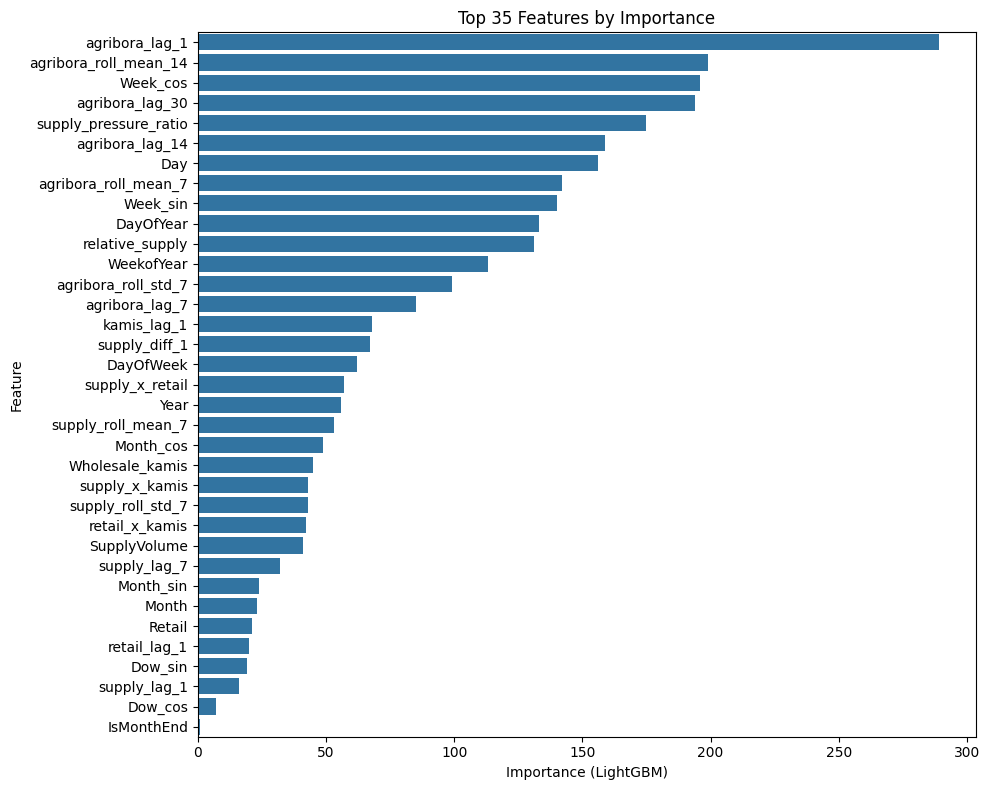

In [7]:
# Visualize the top features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 35 Features by Importance')
plt.xlabel('Importance (LightGBM)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [8]:
# Permutation importance
results = permutation_importance(
    model,
    X,
    y,
    n_repeats   =10,
    random_state=42
)

perm_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': results.importances_mean
}).sort_values('importance', ascending=False)
perm_importance

,feature,importance
20,agribora_lag_1,1.130904
6,WeekofYear,0.084713
18,Week_cos,0.053690
9,DayOfYear,0.034890
23,agribora_lag_30,0.020339
17,Week_sin,0.019439
3,Year,0.017889
38,supply_pressure_ratio,0.014669
25,agribora_roll_mean_14,0.013760
14,Month_cos,0.013739


In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.01))
])

pipeline.fit(X, y)

coef = pd.Series(
    pipeline.named_steps['lasso'].coef_,
    index=X.columns
)

selected = coef.sort_values(ascending=False)
selected

,0
agribora_lag_1,4.251075
agribora_roll_mean_14,1.150135
Month_cos,0.630541
Quarter,0.482901
Month_sin,0.336491
agribora_roll_std_7,0.296765
Wholesale_kamis,0.133832
Year,0.096123
Dow_cos,0.089221
agribora_lag_7,0.057303


In [10]:
numeric_cols = data.select_dtypes(include=np.number)
corr         = numeric_cols.corr()['Wholesale_agribora'].abs().sort_values(ascending=False)
corr

,Wholesale_agribora
Wholesale_agribora,1.000000
agribora_lag_1,0.850445
agribora_roll_mean_7,0.791836
agribora_roll_mean_14,0.755129
agribora_lag_7,0.705032
agribora_lag_14,0.592720
Week_cos,0.492351
Month_cos,0.469491
agribora_lag_30,0.334930
Month_sin,0.194967


In [11]:
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap_importance = pd.DataFrame({
    'feature'   : X.columns,
    'importance': abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

shap_importance

,feature,importance
20,agribora_lag_1,3.489562
6,WeekofYear,0.329904
18,Week_cos,0.236761
9,DayOfYear,0.224572
14,Month_cos,0.133066
17,Week_sin,0.130965
25,agribora_roll_mean_14,0.117971
23,agribora_lag_30,0.115633
3,Year,0.108754
22,agribora_lag_14,0.105232


**Top features**

In [12]:
# Create dataframe with top features
top_features = [
    # Lagged Prices
    'agribora_lag_1', 'agribora_lag_7', 'agribora_lag_14', 'agribora_lag_30',

    # Rolling Prices
    'agribora_roll_mean_7', 'agribora_roll_mean_14', 'agribora_roll_std_7',

    # Supply Features
    'supply_diff_1', 'supply_pressure_ratio', 'relative_supply',
    'SupplyVolume', 'supply_x_retail', 'supply_x_kamis',

    # Price Interactions
    'Retail', 'Wholesale_kamis', 'retail_lag_1', 'retail_x_kamis',

    # Seasonality
    'DayOfYear', 'Week_sin', 'Week_cos', 'Month_sin', 'Month_cos',
    'DayOfWeek', 'WeekofYear'
]

# Columns to keep for context
context_cols = ['County','Market', 'Wholesale_kamis', 'Date']

# target
target = ['Wholesale_agribora']


df_model = data[context_cols + top_features + target].copy()

# Quick check
print("Columns in new model DataFrame:")
print(df_model.columns.tolist())

print("\nFirst 5 rows:")
print(df_model.head())


Columns in new model DataFrame:
['County', 'Market', 'Wholesale_kamis', 'Date', 'agribora_lag_1', 'agribora_lag_7', 'agribora_lag_14', 'agribora_lag_30', 'agribora_roll_mean_7', 'agribora_roll_mean_14', 'agribora_roll_std_7', 'supply_diff_1', 'supply_pressure_ratio', 'relative_supply', 'SupplyVolume', 'supply_x_retail', 'supply_x_kamis', 'Retail', 'Wholesale_kamis', 'retail_lag_1', 'retail_x_kamis', 'DayOfYear', 'Week_sin', 'Week_cos', 'Month_sin', 'Month_cos', 'DayOfWeek', 'WeekofYear', 'Wholesale_agribora']

First 5 rows:
        County    Market  Wholesale_kamis        Date  agribora_lag_1  \
0    Kirinyaga  Business            44.72  2023-11-03          41.110   
1    Kirinyaga  Business            47.22  2023-11-08          43.890   
2  Uasin-Gishu  Business            50.00  2023-11-17          41.110   
3  Uasin-Gishu  Business            50.00  2023-11-27          41.665   
4  Uasin-Gishu  Business            56.39  2023-12-04          43.330   

   agribora_lag_7  agribora_lag

**Encoding**

In [14]:
cat_cols = ["County", "Market"]
target_col = ["Wholesale_agribora"]

# Initialize encoder
cat_encoder = ce.TargetEncoder(
    cols=cat_cols,
    smoothing=5,
    min_samples_leaf=20
)

# Fit + transform data
data[cat_cols] = cat_encoder.fit_transform(
    data[cat_cols],
    data[target_col]
)


In [15]:
joblib.dump(cat_encoder, "cat_encoder.joblib")

['cat_encoder.joblib']

**Train, test and evaluation split**

In [16]:
# Sort by Date to preserve chronology
df_model = df_model.sort_values('Date').reset_index(drop=True)

# Define split ratios
train_ratio = 0.7
eval_ratio = 0.15  # 15% for evaluation
test_ratio = 0.15  # 15% for final test

n = len(df_model)
train_end = int(n * train_ratio)
eval_end = int(n * (train_ratio + eval_ratio))

# Split the data
train_df = df_model.iloc[:train_end].copy()
eval_df = df_model.iloc[train_end:eval_end].copy()
test_df = df_model.iloc[eval_end:].copy()

# 4. Separate features and target
target_col = 'Wholesale_agribora'
feature_cols = [c for c in df_model.columns if c != target_col and c != 'Date']

X_train, y_train = train_df[feature_cols], train_df[target_col]
X_eval, y_eval = eval_df[feature_cols], eval_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# 5. Quick check
print("Training data:", X_train.shape, y_train.shape)
print("Evaluation data:", X_eval.shape, y_eval.shape)
print("Test data:", X_test.shape, y_test.shape)


Training data: (2208, 29) (2208,)
Evaluation data: (473, 29) (473,)
Test data: (474, 29) (474,)


**Ensuring similar distributions between training, evaluation and test data**

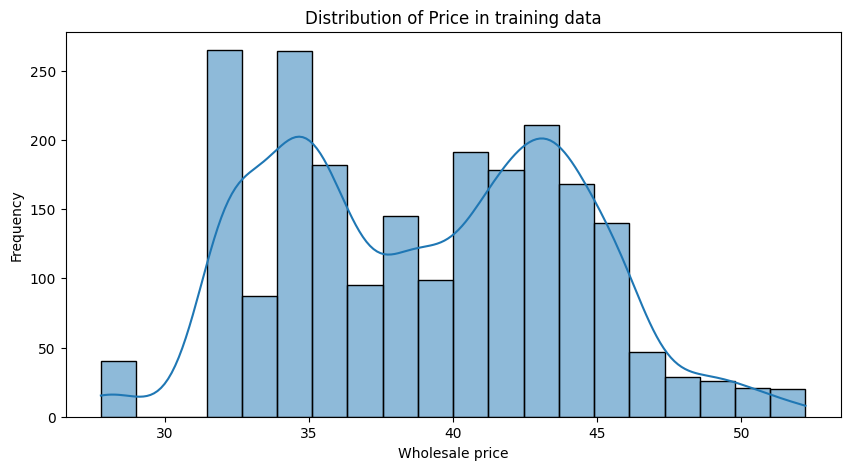

In [18]:
plt.figure(figsize=(10,5))
sns.histplot(y_train, bins=20, kde=True)
plt.title('Distribution of Price in training data')
plt.xlabel('Wholesale price')
plt.ylabel('Frequency')
plt.show()

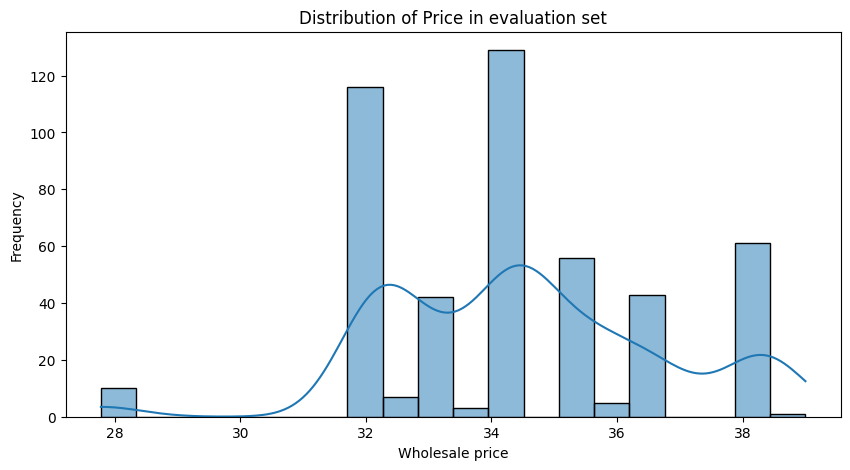

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(y_eval, bins=20, kde=True)
plt.title('Distribution of Price in evaluation set')
plt.xlabel('Wholesale price')
plt.ylabel('Frequency')
plt.show()

Noteworthy: Lower prices and a smaller sample size in the evaluation set reflect underlying price seasonality.

**Save data**

In [20]:
# Generate a timestamp string
timestamp = datetime.now().strftime("%Y%m%d")

# Convert dataframes to csv
X_train.to_csv(f'X_train_{timestamp}.csv', index=False)
X_test.to_csv(f'X_test_{timestamp}.csv', index=False)
X_eval.to_csv(f'X_eval_{timestamp}.csv', index=False)

y_train.to_csv(f'y_train_{timestamp}.csv', index=False)
y_test.to_csv(f'y_test_{timestamp}.csv', index=False)
y_eval.to_csv(f'y_eval_{timestamp}.csv', index=False)


